# Circular Otsu

[Open in Binder](https://mybinder.org/v2/gh/pohlt/scikit-image/co?labpath=__co%2Fco.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from skimage.filters import threshold_otsu

In [2]:
def calc_weighted_variance(x, h):
    omega = h.sum()
    if omega == 0:
        return 0

    mean = (x * h).sum() / omega
    sigma = ((x - mean) ** 2 * h).sum()
    # sigma = (x-m)*h**2
    return sigma

In [ ]:
def otsu(x, h):
    i_min = 9999
    var_min = 1e30
    for i in range(len(x)):
        var = calc_weighted_variance(x[:i], h[:i]) + calc_weighted_variance(x[i:], h[i:])
        if var < var_min:
            var_min = var
            i_min = i
    return x[i_min]


def circular_otsu_naive(x, h):
    H = len(x) // 2

    x = np.hstack([x, x + (x[-1] + x[1] - 2 * x[0])])
    h = np.tile(h, 2)

    i_min = 9999
    sigma_min = 1e30
    for i in range(H):
        sigma_1 = calc_weighted_variance(x[i : H + i], h[i : H + i])
        sigma_2 = calc_weighted_variance(x[H + i : 2 * H + i], h[H + i : 2 * H + i])
        sigma = sigma_1 + sigma_2

        if sigma < sigma_min:
            sigma_min = sigma
            i_min = i

        print(i, sigma_1, sigma_2, sigma)

    return x[i_min % (2 * H)], x[(i_min + H) % (2 * H)]


def circular_otsu_less(x, h):
    H = len(x) // 2

    x = np.hstack([x, x + (x[-1] + x[1] - 2 * x[0])])
    h = np.tile(h, 2)

    i_min = 9999
    sigma_min = 1e30
    sigma_1 = 0
    sigma_2 = 0
    for i in range(H):
        if sigma_1 > sigma_2:
            sigma_1 = calc_weighted_variance(x[i : H + i], h[i : H + i])
            if sigma_1 >= sigma_min:
                continue
            else:
                sigma_2 = calc_weighted_variance(x[H + i : 2 * H + i], h[H + i : 2 * H + i])
        else:
            sigma_2 = calc_weighted_variance(x[H + i : 2 * H + i], h[H + i : 2 * H + i])
            if sigma_2 >= sigma_min:
                continue
            else:
                sigma_1 = calc_weighted_variance(x[i : H + i], h[i : H + i])

        sigma = sigma_1 + sigma_2

        if sigma < sigma_min:
            sigma_min = sigma
            i_min = i

    return x[i_min % (2 * H)], x[(i_min + H) % (2 * H)]


3
12.199257890716392 12.199257890716392 9.1295259037453 9.1295259037453
16.52856516057628 16.52856516057628 18.415674289620302 18.415674289620306
10.838022181648327 10.838022181648327 7.617361476786979 7.617361476786979


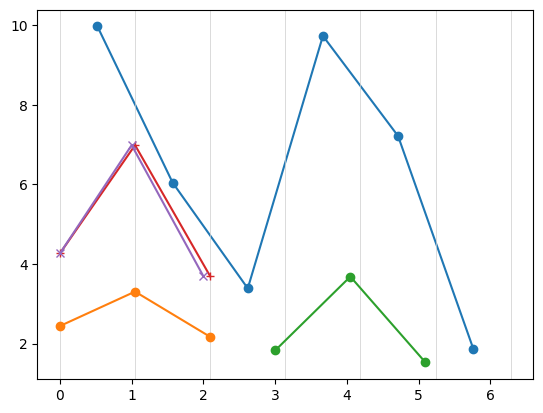

In [4]:
N = 6
assert N % 2 == 0, "number of bins must be even"

# histogram assumptions: bin centers; uniforms bin size
x = np.linspace(0, 2 * np.pi, N, endpoint=False)
SS = (x[-1] - x[0]) / (N - 1)
x += 0.5 * SS

R = SS * N
h = np.abs(np.sin(1 + 0.95 * x)) * 10

plt.plot(x, h, marker="o")
for l in np.linspace(0, R, N + 1):
    plt.axvline(l, c="#cccccc", lw=0.5)

H = len(x) // 2
print(H)

x = np.hstack([x, x + (x[-1] + x[1] - 2 * x[0])])
h = np.tile(h, 2)

# plt.plot(x, h, marker="o")

w = np.hstack([[0], np.cumsum(h)])
m = np.hstack([[0], np.cumsum(x * h)])


def gh(s, i: int) -> float:
    return s[i + H] - s[i]
    if i == 0:
        return s[i + H - 1]
    else:
        return s[i + H - 1] - s[i - 1]


v = []
s1 = []
s2 = []
s = []
t = []
for i in range(H):
    sigma_1 = calc_weighted_variance(x[i : i + H], h[i : i + H])
    sigma_2 = calc_weighted_variance(x[i + H : i + 2 * H], h[i + H : i + 2 * H])
    sigma = sigma_1 + sigma_2
    v.append(x[i])
    s1.append(0.2 * sigma_1)
    s2.append(0.2 * sigma_2)
    s.append(0.2 * sigma)
    omega = w[i + H] - w[i]
    mean = (m[i + H] - m[i]) / omega
    sigma_alt_1 = ((x[i : i + H] - mean) ** 2 * h[i : i + H]).sum()
    omega_2 = w[i + 2 * H] - w[i + H]
    mean_2 = (m[i + 2 * H] - m[i + H]) / omega_2
    sigma_alt_2 = ((x[i + H : i + 2 * H] - mean_2) ** 2 * h[i + H : i + 2 * H]).sum()
    print(sigma_1, sigma_alt_1, sigma_2, sigma_alt_2)

    t.append(0.2 * (sigma_alt_1 + sigma_alt_2))

_ = plt.plot(np.asarray(v) - 0.5 * SS, s1, marker="o")
_ = plt.plot(np.asarray(v) - 0.5 * SS + H, s2, marker="o")
_ = plt.plot(np.asarray(v) - 0.5 * SS, s, marker="+")
_ = plt.plot(t, marker="x")


# _ = plt.plot(4 * (m[H:] - m[:-H] - 1.0), marker="o")
# _ = plt.plot(m[H:] - m[H:], marker="o")

In [5]:
def circular_otsu_test(x, h):
    H = len(x) // 2

    x = np.hstack([x, x + (x[-1] + x[1] - 2 * x[0])])
    h = np.tile(h, 2)

    i_min = 9999
    sigma_min = 1e30
    w = np.hstack([[0], np.cumsum(h)])
    m = np.hstack([[0], np.cumsum(x * h)])

    for i in range(H):
        omega_1 = w[i + H] - w[i]
        mean_1 = (m[i + H] - m[i]) / omega_1
        sigma_1 = ((x[i : i + H] - mean_1) ** 2 * h[i : i + H]).sum()

        omega_2 = w[i + 2 * H] - w[i + H]
        mean_2 = (m[i + 2 * H] - m[i + H]) / omega_2
        sigma_2 = ((x[i + H : i + 2 * H] - mean_2) ** 2 * h[i + H : i + 2 * H]).sum()

        sigma = sigma_1 + sigma_2

        if sigma < sigma_min:
            sigma_min = sigma
            i_min = i

    return x[i_min % (2 * H)], x[(i_min + H) % (2 * H)]

In [ ]:
def circular_otsu_updater(x, h, x_range=(-10 / 3, 20 / 3)):
    lx = len(x)
    lx2 = lx // 2
    assert lx % 2 == 0, "number of bins must be even"

    xe = np.tile(x, 2)
    xe[lx:] += x_range[1] - x_range[0]
    he = np.tile(h, 2)

    def init(x, h) -> tuple[float, float, float]:
        omega = h.sum()
        mean = (x * h).sum()
        return omega, mean, (np.square(x - mean / omega) * h).sum()

    def update(ia: int, ie: int, omega: float, mean: float) -> tuple[float, float, float]:
        omega += he[ie] - he[ia]
        mean += xe[ie] * he[ie] - xe[ia] * he[ia]
        ia += 1
        ie += 1
        return (
            omega,
            mean,
            (np.square(xe[ia:ie] - mean / omega) * he[ia:ie]).sum(),
        )

    omega_1, mean_1, sigma_1 = init(xe[:lx2], he[:lx2])
    omega_2, mean_2, sigma_2 = init(xe[lx2:lx], he[lx2:lx])

    sigma_min = sigma_1 + sigma_2
    i_min = 0

    for i in range(lx2 - 1):
        omega_1, mean_1, sigma_1 = update(i, i + lx2, omega_1, mean_1)
        omega_2, mean_2, sigma_2 = update(i + lx2, i + lx, omega_2, mean_2)
        sigma = sigma_1 + sigma_2

        if sigma < sigma_min:
            sigma_min = sigma
            i_min = i + 1

    x_min = x[i_min]
    return x_min, x_min + 0.5 * (x_range[1] - x_range[0])

In [91]:
import time


gaussian = lambda x, x0, a, s: a * np.exp(-np.square(x - x0) / (2 * s * s))
functions = dict(
    naive=circular_otsu_naive,
    less=circular_otsu_less,
    updater=circular_otsu_updater,
    test=circular_otsu_test,
)
W = 10


@interact(
    p1=(0.1, 0.9, 0.01),
    p2=(0.1, 0.9, 0.01),
    noise=(0, 0.1, 0.01),
    roll=(-0.65, 0.65, 0.05),
    N=(4, 500, 2),
    impl=functions.keys(),
)
def aux(
    p1=0.4,
    p2=0.54,
    N=256,
    roll=0,
    noise=0.01,
    impl="naive",
):
    x = np.linspace(-W, 2 * W, 3 * N, endpoint=False, dtype=np.float32)
    h = noise * np.random.random(x.shape).astype(np.float32)
    h += gaussian(x, p1 * W + roll * W, 1, 0.5)
    h += gaussian(x, p2 * W + roll * W, 0.5, 0.5)
    h[N : 2 * N] += h[0:N]
    h[N : 2 * N] += h[2 * N : 3 * N]

    bins = x + 0.5 * (x[1] - x[0])
    bins = bins[N : 2 * N]
    x = x[N : 2 * N]
    h = h[N : 2 * N]

    _, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x, h, c="#000", label="histogram")

    start = time.perf_counter()
    for _ in range(1):
        co_th = functions[impl](x, h)
    end = time.perf_counter()
    print(co_th)

    for th in co_th:
        ax.axvline(th, c="#f00", label=impl + " circular otsu", lw=2, alpha=0.3)

    ax.axvline(
        threshold_otsu(hist=(h, bins)),
        c="#00f",
        label="linear Otsu",
        ls="dotted",
        lw=2,
        alpha=0.3,
    )
    ax.set_title(f"calculation time: {1 * (end - start):.3f} ms")
    ax.legend(loc="lower right")


interactive(children=(FloatSlider(value=0.4, description='p1', max=0.9, min=0.1, step=0.01), FloatSlider(value…

In [92]:
@interact(
    roll=(-13, 13, 1),
    N=(6, 26, 2),
    impl=functions.keys(),
)
def aux(
    N=6,
    roll=0,
    impl="naive",
):
    x = np.linspace(-10 / 3, 20 / 3, N, endpoint=False, dtype=np.float32)
    h = np.sin(0.4 * x + 0.3) ** 2
    h = np.roll(h, roll)

    _, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x, h, c="#000", label="histogram", marker="o")

    co_th = functions[impl](x, h)
    print(co_th)

    for th in co_th:
        ax.axvline(th, c="#f00", label=impl + " circular otsu", lw=2, alpha=0.3)

    ax.axvline(
        threshold_otsu(hist=(h, x)),
        c="#00f",
        label="linear Otsu",
        ls="dotted",
        lw=2,
        alpha=0.3,
    )
    ax.legend(loc="lower right")

interactive(children=(IntSlider(value=6, description='N', max=26, min=6, step=2), IntSlider(value=0, descripti…

0 11.930497 12.177689 24.108185
1 12.469433 15.867781 28.337214
2 10.672722 17.689291 28.362013
3 7.850663 17.776985 25.627647
4 5.6971216 16.406448 22.103569
5 5.0923333 13.971608 19.063942
6 6.0222707 10.951773 16.974043
7 7.9841156 7.8727765 15.856892
8 10.329793 5.266748 15.59654
9 12.454901 3.6302254 16.085127
10 13.890382 3.367284 17.257666
11 14.347084 4.704336 19.05142
12 13.736739 7.6273975 21.364136


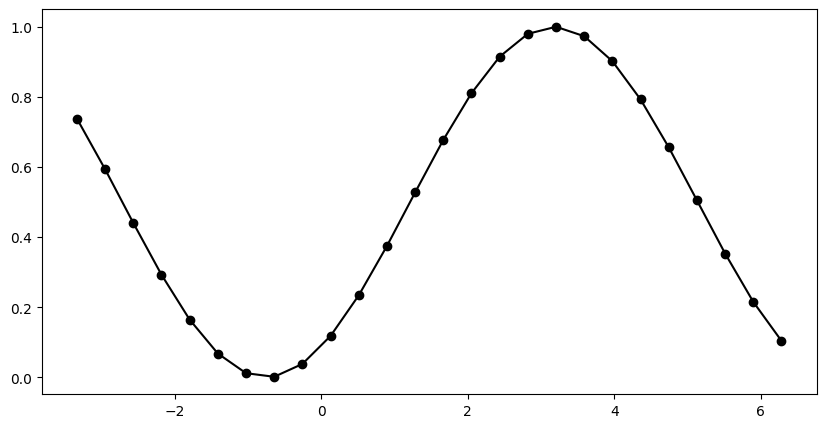

In [79]:
x_range = (-10 / 3, 20 / 3)


def circular_otsu_naive2(x, h):
    H = len(x) // 2

    # x = np.hstack([x, x + (x[-1] + x[1] - 2 * x[0])])
    x = np.tile(x, 2)
    x[2 * H :] += x_range[1] - x_range[0]
    h = np.tile(h, 2)
    plt.plot(x, h)

    i_min = 9999
    sigma_min = 1e30
    s = []
    for i in range(H):
        sigma_1 = calc_weighted_variance(x[i : H + i], h[i : H + i])
        sigma_2 = calc_weighted_variance(x[H + i : 2 * H + i], h[H + i : 2 * H + i])
        sigma = sigma_1 + sigma_2
        s.append(sigma)

        if sigma < sigma_min:
            sigma_min = sigma
            i_min = i

    plt.plot(0.5 * np.asarray(s), marker="o")
    print(s)
    return x[i_min % (2 * H)], x[(i_min + H) % (2 * H)]


N = 26
roll = 0
x = np.linspace(-10 / 3, 20 / 3, N, endpoint=False, dtype=np.float32)
h = np.sin(0.4 * x + 0.3) ** 2
h = np.roll(h, roll)

_, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, h, c="#000", label="histogram", marker="o")
co_th = circular_otsu_naive(x, h)


[100.          76.74356374   6.28318054]


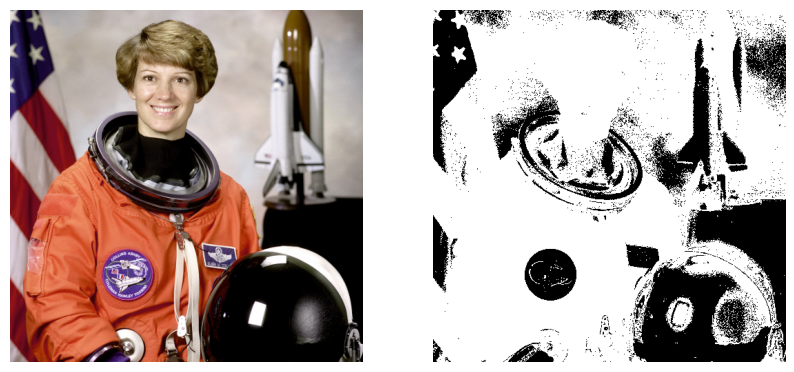

In [ ]:
import numpy as np
from skimage.filters import threshold_circular_otsu
from skimage.color import rgb2lab, lab2lch, lab2rgb, lch2lab, hsv2rgb
from skimage import data
import matplotlib.pyplot as plt

img = data.astronaut()
# img = data.chelsea()
# img = data.coffee()
# img = data.rocket()
# img = data.colorwheel()
# img = data.lily()[..., :3] / 4095
hue = lab2lch(rgb2lab(img))[..., 2]
print(lab2lch(rgb2lab(img)).max(axis=(0, 1)))
t = threshold_circular_otsu(hue, val_range=(0, 2 * np.pi))
th_img = np.zeros(hue.shape, dtype=np.uint8)
th_img[(hue < t[0]) | (hue > t[1])] = 1
th_img = 1 - th_img
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(th_img, cmap="gray")
for a in ax:
    a.axis("off")

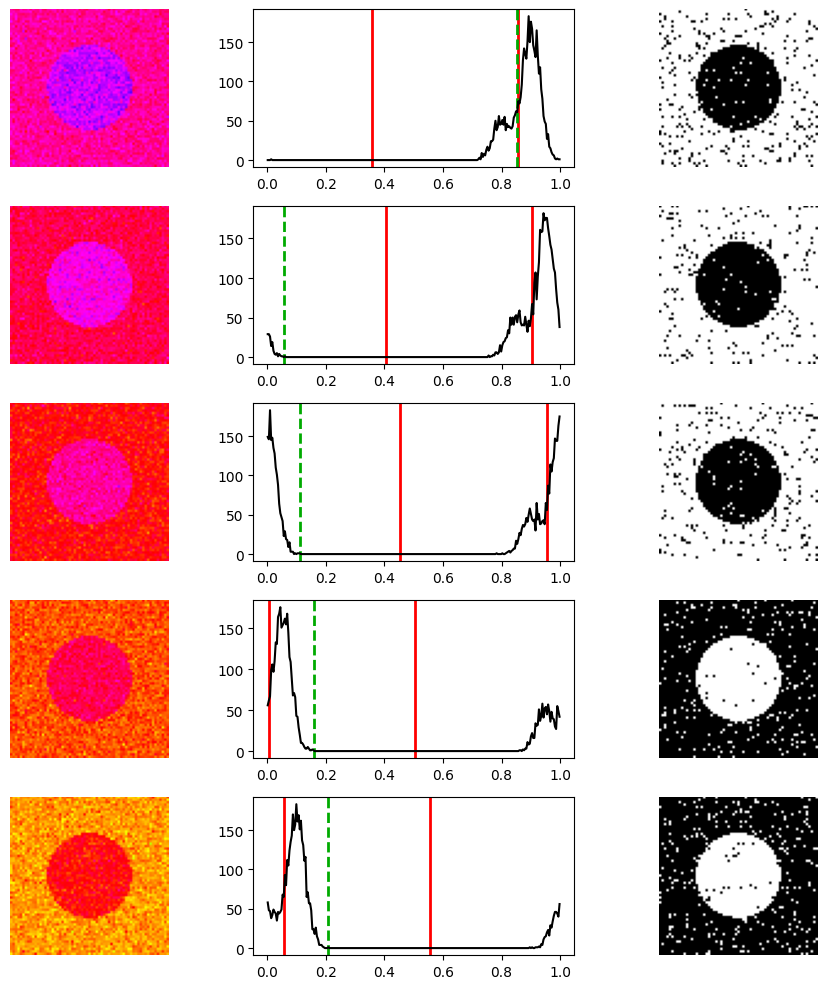

In [ ]:
from skimage.color.colorconv import hsv2rgb
from skimage.filters import threshold_circular_otsu, threshold_otsu

mask = np.fromfunction(lambda r, c: (r - 32) ** 2 + (c - 32) ** 2 < 300, (65, 65))

fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i in range(5):
    img_hsv = np.ones((*mask.shape, 3), dtype=np.float32)
    hue = img_hsv[..., 0]
    hue[...] = np.where(mask, 0.8, 0.9)
    hue += 0.05 * i
    hue += np.random.normal(0, 0.03, mask.shape)
    hue %= 1.0
    img_rgb = hsv2rgb(img_hsv)

    ax[i, 0].imshow(img_rgb)
    ax[i, 0].axis("off")

    c, x = np.histogram(hue, 256, (0, 1))
    t = threshold_circular_otsu(hue, val_range=(0, 1))
    # equivalent:
    # t = threshold_circular_otsu(val_range=(0, 1), hist=c)
    for v in t:
        ax[i, 1].axvline(v, c="#f00f", lw=2)
    ax[i, 1].axvline(threshold_otsu(hue), c="#0a0", ls="dashed", lw=2)
    ax[i, 1].plot(0.5 * (x[1:] + x[:-1]), c, color="#000")

    ax[i, 2].imshow((hue < t[0]) | (hue > t[1]), cmap="gray")
    ax[i, 2].axis("off")
plt.tight_layout()